In [21]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import shap
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#  data 
file_path = r"C:\Users\alina\Downloads\train.csv"
df = pd.read_csv(file_path, delimiter=",")
# Drop identifiers
df = df.drop(['ID'], axis=1)

# Separate features and target
y = df['Label']
X = df.drop('Label', axis=1)

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

In [ ]:

# Preprocessing 
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Modeling pipeline with SMOTE to handle class imbalance
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])


In [24]:

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='accuracy')

print(f"XGBoost Accuracy: {xgb_scores.mean():.3f} ± {xgb_scores.std():.3f}")


XGBoost Accuracy: 0.867 ± 0.017


In [25]:

# Train/test split for further analysis
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Fit model
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

# Predict probabilities for AUC
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report (XGBoost):\n")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.3f}")



Classification Report (XGBoost):

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       184
           1       0.57      0.44      0.50        36

    accuracy                           0.85       220
   macro avg       0.73      0.69      0.71       220
weighted avg       0.84      0.85      0.85       220

AUC Score: 0.796


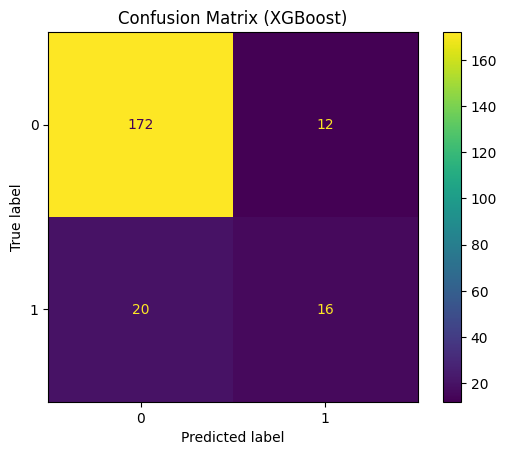

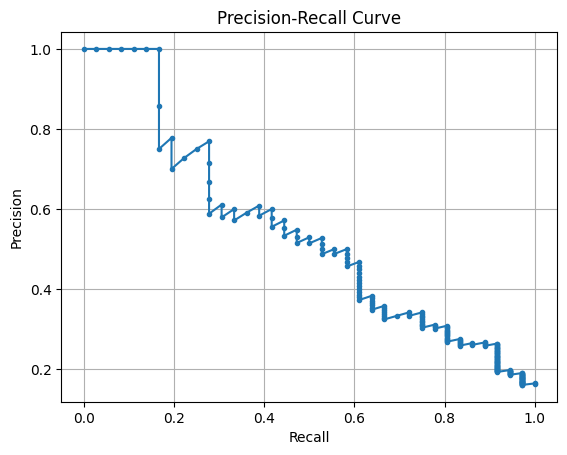

In [26]:


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


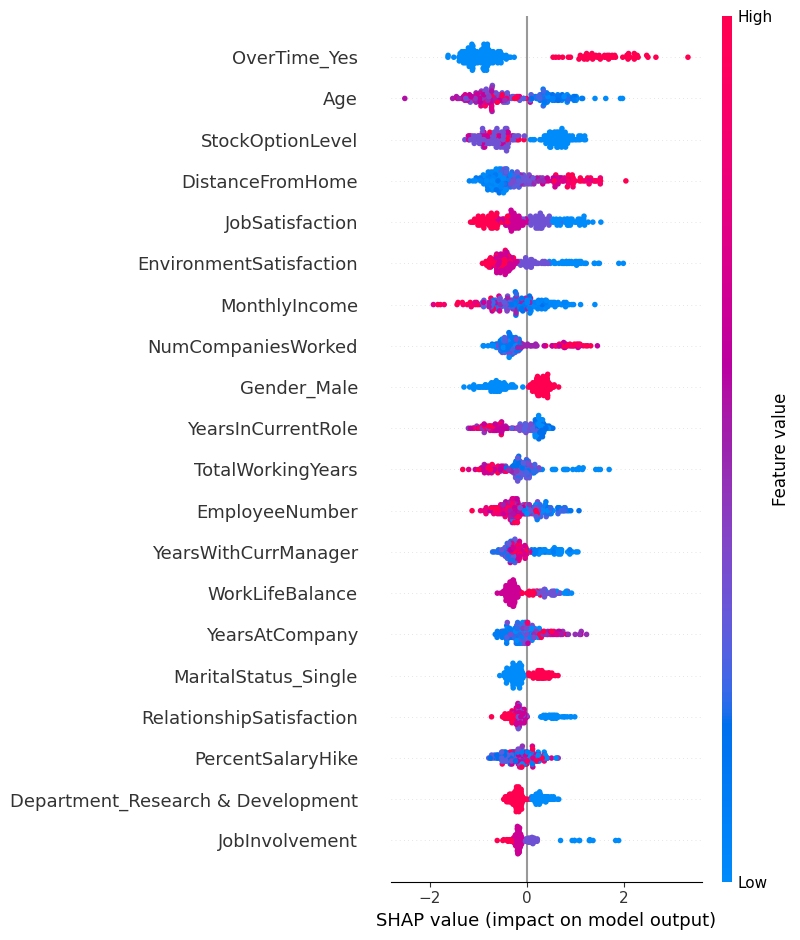

In [27]:

# SHAP explainability
# Re-fit on full data without pipeline for SHAP
X_encoded = pd.get_dummies(X, drop_first=True)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_enc, y_train_enc)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_enc)
shap.summary_plot(shap_values, X_test_enc)


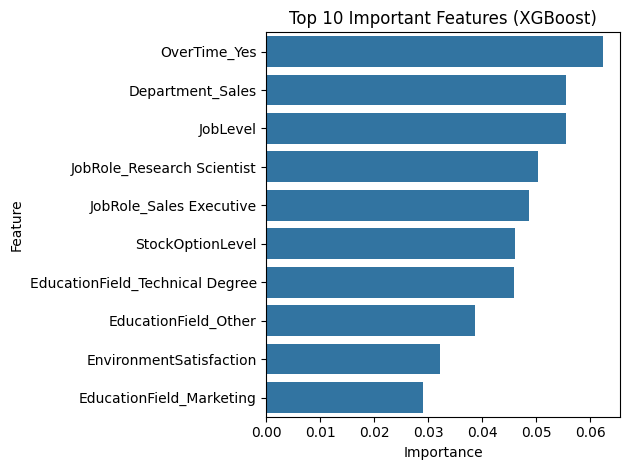


High-risk employee breakdown by department:
Department_Research & Development    10
Department_Sales                      6
dtype: int64

High-risk Employee IDs:
[1175, 1844, 297, 22, 749, 33, 1055, 554, 1079, 819, 493, 1269, 1605, 1100, 514, 440, 235]


In [28]:

# Feature Importance Plot
importances = xgb_model.feature_importances_
feat_importance = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False).head(10)

sns.barplot(data=feat_importance, x='Importance', y='Feature')
plt.title("Top 10 Important Features (XGBoost)")
plt.tight_layout()
plt.show()

# Example: flagging high-risk employees
risk_threshold = 0.7
X_test_enc['Predicted Risk'] = xgb_model.predict_proba(X_test_enc)[:, 1]
X_test_enc['True Label'] = y_test_enc.values
high_risk = X_test_enc[X_test_enc['Predicted Risk'] > risk_threshold]

print("\nHigh-risk employee breakdown by department:")
print(high_risk.filter(like='Department').sum())

print("\nHigh-risk Employee IDs:")
print(high_risk['EmployeeNumber'].tolist())
